# Sample FFT code

## Install dependencies

In [44]:
%pip install matplotlib numpy influxdb_client

39551.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Python code

In [45]:
import re
import json
import matplotlib.pyplot as plt
import numpy as np

from influxdb_client import InfluxDBClient

In [46]:
def load_constants(file_path):
    constants_dict = {}
    with open(file_path, 'r', encoding="UTF-8") as file:
        content = file.read()
        #print(content)
        # Match lines containing constant definitions
        constant_lines = re.findall(r'#define\s+(\w+)\s+"([^"]+)"', content)
        for name, value in constant_lines:
            constants_dict[name] = value
    #print(constants_dict)
    return constants_dict

In [47]:
def get_from_influx(url: str, token: str, org: str, bucket: str, sensorname: str) -> list[list[float]]:
    # Initialize the client
    client = InfluxDBClient(url=url, token=token, org=org)

    # Define the query
    query = f"""
    from(bucket: "{bucket}")
    |> range(start: -12h, stop: now())
    |> filter(fn: (r) => r["_measurement"] == "garden_fft_data")
    |> filter(fn: (r) => r["_field"] == "json_data")
    |> filter(fn: (r) => r["device"] == "{sensorname}")
    |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
    |> yield(name: "last")
    |> sort(columns: ["_time"], desc: true)
    """

    # Execute the query
    result = client.query_api().query(query)

    # List containing data arrays
    data_list = []
    
    # Print the results
    for table in result:
        for record in table.records:
            #print(str(record["_time"]) + " - " + record["_value"])
            json_list = json.loads(record["_value"])
            # Extracting data array
            data_array = json_list['data']
            # Printing the data array
            #print(data_array)
            data_list.append(data_array)
            
    return data_list

In [48]:
def plot_data(data_list: list[list[float]]):
    # Convert the data to a numpy array
    data_array = np.array(data_list)

    # Create the heatmap
    plt.imshow(data_array, cmap='viridis', interpolation='nearest')

    # Add color bar
    plt.colorbar()
    plt.clim(0, 100)

    # Add labels
    plt.xlabel('Frequency')
    plt.ylabel('Minutes ago')
    plt.title('FFT Results')

    # Show plot
    plt.show()

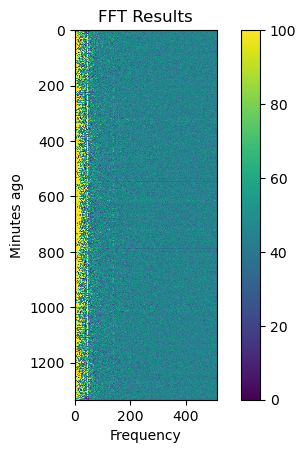

In [49]:
if __name__ == "__main__":
    FILE_PATH = "../include/secrets.h"  # Path to your .h file
    constants = load_constants(FILE_PATH)
    data = get_from_influx(constants["INFLUXDB_URL"], constants["INFLUXDB_TOKEN"], constants["INFLUXDB_ORG"], constants["INFLUXDB_BUCKET"], constants["SENSOR_NAME"])
    plot_data(data)